In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use(r'mplstyle')

import matplotlib as mpl
import pandas as pd
from sklearn.svm import SVC
from sklearn.utils import resample
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation
from scipy.optimize import minimize

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fed9ae', '#fbad54']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [7]:
def fit_svc(data, label):
    svc = SVC(kernel = 'linear', class_weight = 'balanced')
    svc.fit(data, label)
    w = svc.coef_[0]           # w consists of 2 elements
    a = - svc.intercept_[0] / w[1]
    b = - w[0] / w[1] 
    return a, b

def analyse_loglog_data(xx, yy, label, repeats = 50, nsample = 5000):
    # fit power law
    lnx = np.log10(xx)
    lny = np.log10(yy)
    data = np.array([lnx, lny]).T
    
    molar_ratio = []
    B = []
    A = []
    for _ in range(repeats):
        print(_, end = '\r')
        data_resampled, label_resampled = resample(data, label, replace = True, n_samples = min(nsample, len(data)))
        a, b = fit_svc(data_resampled, label_resampled)
        # a, b = fit_crosstalk(data_resampled, label_resampled, x0 = [b, a])
        molar_ratio.append(-1/b)
        B.append(b)
        A.append(a)
    molar_ratio_avg = np.mean(molar_ratio)
    molar_ratio_std = np.std(molar_ratio)
    B_avg = np.mean(B)
    B_std = np.std(B)
    A_avg = np.mean(A)
    A_std = np.std(A)
    
    return [molar_ratio_avg, molar_ratio_std, A_avg, A_std, B_avg, B_std]

In [8]:
# NSP5/NSP2 dataset

df = pd.read_csv('../data/NSP.csv').sample(frac = 1).dropna()
xx = df[r'NSP2 / uM'].values
yy = df[r'NSP5 / uM'].values
xlabel = r'[NSP2](uM)'
ylabel = r'[NSP5](uM)'

In [9]:
res = analyse_loglog_data(xx, yy, df['feature'].values, repeats = 50, nsample = 800)
print(r'molar ratio of {0} against {1} is {2:.3f}+-{3:.3f}'.format(ylabel, xlabel, res[0], res[1]))

molar ratio of [NSP5](uM) against [NSP2](uM) is 2.668+-0.887


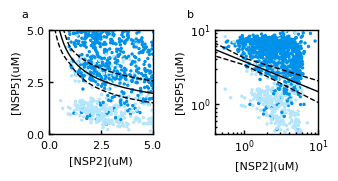

In [10]:
fig, axes = plt.subplots(1, 2, figsize = cm2inch(8.7,4.7))

xlim_lin = [0, 5]
xlim_log = [4e-1, 1e1]

ylim_lin = [0, 5]
ylim_log = [4e-1, 1e1]

cc = [colors[0][i] for i in df['feature'].values.astype(int)]
ed = [('white' if i == 1 else 'grey') for i in df['feature'].values.astype(int)]
[molar_ratio_avg, molar_ratio_std, A_avg, A_std, B_avg, B_std] = res

x_fit = np.linspace(1e-2, 1e2, 1000)
y_fit_avg = 10 ** A_avg * x_fit ** B_avg
y_fit_iter = []
for _1 in [-1, +1]:
    for _2 in [-1, +1]:
        y_fit_iter.append(10 ** (A_avg + _1 * A_std) * x_fit ** (B_avg + _2 * B_std))
y_fit_max = np.max(y_fit_iter, axis = 0)
y_fit_min = np.min(y_fit_iter, axis = 0)

for i in range(2):
    axes[i].scatter(xx, yy, c = cc, s = 2) # , edgecolor = ed, lw = 0.1)
    axes[i].set_xlabel(xlabel)

    axes[i].plot(x_fit, y_fit_avg, color = 'black', lw = 1)
    # axes[i].fill_between(x_fit, y_fit_min, y_fit_max, color = 'white', alpha = 0.1, linewidth = 0)
    axes[i].plot(x_fit, y_fit_min, color = 'black', lw = 1, linestyle = 'dashed')
    axes[i].plot(x_fit, y_fit_max, color = 'black', lw = 1, linestyle = 'dashed')

axes[1].set_xscale('log')
axes[1].set_yscale('log')

axes[1].set_xlim(*xlim_log)
axes[1].set_ylim(*ylim_log)

axes[0].set_xlim(*xlim_lin)
axes[0].set_ylim(*ylim_lin)
axes[0].set_xlabel(xlabel)
axes[0].set_ylabel(ylabel)
axes[0].set_xticks(np.linspace(*xlim_lin, 3))
axes[0].set_yticks(np.linspace(*ylim_lin, 3))

axes[0].text(0.0, 1.0, r'a',
             transform = (axes[0].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
             va='bottom')

axes[1].text(0.0, 1.0, r'b',
             transform = (axes[1].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
             va='bottom')

axes[0].set_ylabel(ylabel)
axes[1].set_ylabel(ylabel)

plt.tight_layout()
plt.savefig('plots/NSP_fitting.pdf')